In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !sudo rm -r /content/consultancy/
!sudo cp -r /content/drive/MyDrive/consultancy/ /content/

In [30]:
%cd /content/consultancy/

/content/consultancy


# 1. Import Libraries

In [31]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

# 2. Upload Datasets For Stock Data And News Headlines

In [32]:
# stock_price = pd.read_csv('/content/consultancy/^BSESN.csv')
stock_headlines = pd.read_csv('/content/consultancy/india-news-headlines.csv')

In [33]:
print("a => Nifty50")
print("b => BSE Sensex")
option = input("Select file")
if option=="a":
  File = "^NSEI.csv"
elif option == "b":
  File = "BSE.csv"

path = "/content/consultancy/" + File

stock_price = pd.read_csv(path, index_col=False)

a => Nifty50
b => BSE Sensex
Select fileb


# 3. Data Cleaning

In [34]:
stock_price.tail()

,Date,Open,High,Low,Close
3601,16-July-2021,53244.40,53290.81,52997.09,53140.06
3602,19-July-2021,52606.99,52821.17,52405.89,52553.40
3603,20-July-2021,52432.88,52465.03,52013.51,52198.51
3604,22-July-2021,52494.56,52867.26,52471.23,52837.21
3605,23-July-2021,52967.87,53114.70,52653.77,52975.80


In [35]:
stock_headlines.tail()

,publish_date,headline_category,headline_text
3424062,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,removed,Govt extends deadline for use of FASTag till F...
3424066,20201231,entertainment.bengali.movies.news,Celebs plan to party safely and responsibly on...


In [38]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(3606, 3424067)

In [39]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date     False
 Open     False
 High     False
 Low      False
 Close    False
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

# 3.1. Numerical Stock Data

In [40]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low
Date,,,,
2007-01-02,13942.24,13827.77,13980.54,13797.44
2007-01-03,14014.92,13969.45,14035.67,13897.42
2007-01-04,13871.71,14029.04,14060.35,13850.38
2007-01-05,13860.52,13768.79,13971.82,13763.39
2007-01-08,13652.15,13855.89,13855.89,13599.87
...,...,...,...,...
2021-07-16,53140.06,53244.40,53290.81,52997.09
2021-07-19,52553.40,52606.99,52821.17,52405.89
2021-07-20,52198.51,52432.88,52465.03,52013.51


# 3.2. Textual News Headlines Data

In [41]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


# Appending new headlines

In [42]:
# !sudo rm new_headlines.csv

In [43]:
df_new = pd.read_csv('new_headlines.csv')
df_new = df_new.filter(['publish_date', 'headline_text'])
df_new.set_index('publish_date', inplace= True)
df_new

,headline_text
publish_date,
2021-01-01,F&O data hints Nifty in for a breather after l...
2021-01-02,"Sebi fines Reliance Industries, Mukesh Ambani,..."
2021-01-03,Five Indian cricketers isolated after apparent...
2021-01-04,Coworking firms opt for revenue share model to...
2021-01-05,Fiat Chrysler set to invest $400 million in it...
...,...
2021-07-18,"Pawar meets PM Modi, red flags change in law t..."
2021-07-19,BJP-RSS meet discusses coordination
2021-07-20,Supreme Court orders release of activist held ...


In [44]:
stock_headlines = pd.concat([stock_headlines, df_new])

In [45]:
stock_headlines.index = pd.to_datetime(stock_headlines.index)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2021-07-18,"Pawar meets PM Modi, red flags change in law t..."
2021-07-19,BJP-RSS meet discusses coordination
2021-07-20,Supreme Court orders release of activist held ...


In [46]:
stock_headlines[-150:-140]

,headline_text
publish_date,
2021-02-23,Carlsberg’s probes reveal details of ‘potentia...
2021-02-24,Upward spiral of diesel and petrol prices like...
2021-02-25,Finance ministry to set up Working Group to re...
2021-02-26,China celebrates official end of extreme pover...
2021-02-27,US drops demand for 'safe harbour' in global t...
2021-02-28,"Assam firm mistakenly shown as ‘Quippo’, staff..."
2021-03-01,"View: With an aim to boost the Indian market, ..."
2021-03-02,Finance Minister: NSE glitch cost govt immensely
2021-03-03,Comorbidity list to qualify for a Covid jab to...


# 4. Combine Stock Data

In [47]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data


,Close,Open,High,Low,headline_text
2007-01-02,13942.24,13827.77,13980.54,13797.44,Q&A: Innovation is the norm across sectors in ...
2007-01-03,14014.92,13969.45,14035.67,13897.42,"Creating A Personal Sacred Space,Winter Musing..."
2007-01-04,13871.71,14029.04,14060.35,13850.38,"Marshal your thoughts for tranquillity,Elixir ..."
2007-01-05,13860.52,13768.79,13971.82,13763.39,"Red tape fails to bind Pak team,Zardari is pay..."
2007-01-08,13652.15,13855.89,13855.89,13599.87,"Asha Bhonsle to croon with Robbie Williams,Scr..."
...,...,...,...,...,...
2021-07-15,53158.85,52968.89,53266.12,52948.43,Submarine building project: MDL’s extended und...
2021-07-16,53140.06,53244.40,53290.81,52997.09,In the run-up to up assembly elections: BJP le...
2021-07-19,52553.40,52606.99,52821.17,52405.89,BJP-RSS meet discusses coordination
2021-07-20,52198.51,52432.88,52465.03,52013.51,Supreme Court orders release of activist held ...


In [48]:
#alternate way is to use merge funtion and inner join operation 
pd.merge(stock_price, stock_headlines, left_index=True, right_index=True, how='inner')

,Close,Open,High,Low,headline_text
2007-01-02,13942.24,13827.77,13980.54,13797.44,Q&A: Innovation is the norm across sectors in ...
2007-01-03,14014.92,13969.45,14035.67,13897.42,"Creating A Personal Sacred Space,Winter Musing..."
2007-01-04,13871.71,14029.04,14060.35,13850.38,"Marshal your thoughts for tranquillity,Elixir ..."
2007-01-05,13860.52,13768.79,13971.82,13763.39,"Red tape fails to bind Pak team,Zardari is pay..."
2007-01-08,13652.15,13855.89,13855.89,13599.87,"Asha Bhonsle to croon with Robbie Williams,Scr..."
...,...,...,...,...,...
2021-07-15,53158.85,52968.89,53266.12,52948.43,Submarine building project: MDL’s extended und...
2021-07-16,53140.06,53244.40,53290.81,52997.09,In the run-up to up assembly elections: BJP le...
2021-07-19,52553.40,52606.99,52821.17,52405.89,BJP-RSS meet discusses coordination
2021-07-20,52198.51,52432.88,52465.03,52013.51,Supreme Court orders release of activist held ...


# 5. Sentiment Analysis

In [49]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,headline_text,compound,negative,neutral,positive
2007-01-02,13942.24,13827.77,13980.54,13797.44,Q&A: Innovation is the norm across sectors in ...,,,,
2007-01-03,14014.92,13969.45,14035.67,13897.42,"Creating A Personal Sacred Space,Winter Musing...",,,,
2007-01-04,13871.71,14029.04,14060.35,13850.38,"Marshal your thoughts for tranquillity,Elixir ...",,,,
2007-01-05,13860.52,13768.79,13971.82,13763.39,"Red tape fails to bind Pak team,Zardari is pay...",,,,
2007-01-08,13652.15,13855.89,13855.89,13599.87,"Asha Bhonsle to croon with Robbie Williams,Scr...",,,,


In [50]:
 import nltk
 nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [51]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos']) 

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,headline_text,compound,negative,neutral,positive
2007-01-02,13942.24,13827.77,13980.54,13797.44,Q&A: Innovation is the norm across sectors in ...,-0.9959,0.162,0.733,0.104
2007-01-03,14014.92,13969.45,14035.67,13897.42,"Creating A Personal Sacred Space,Winter Musing...",-0.9942,0.126,0.804,0.070
2007-01-04,13871.71,14029.04,14060.35,13850.38,"Marshal your thoughts for tranquillity,Elixir ...",-0.9979,0.175,0.742,0.082
2007-01-05,13860.52,13768.79,13971.82,13763.39,"Red tape fails to bind Pak team,Zardari is pay...",-0.9978,0.133,0.815,0.052
2007-01-08,13652.15,13855.89,13855.89,13599.87,"Asha Bhonsle to croon with Robbie Williams,Scr...",-0.9912,0.117,0.793,0.090


In [ ]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
# stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]
if option=="a":
  stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]
elif option=="b":
  stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low']]
# set the index name
stock_data.index.name = 'Date'

# displaying the final stock_data
stock_data.head()

#### Adding Returns Column

In [57]:
stock_data['monthly_return'] = ((stock_data['Close'].shift(-30) - stock_data['Close'])/stock_data['Close'])*100
stock_data['yearly_return'] = ((stock_data['Close'].shift(-365)-stock_data['Close'])/stock_data['Close'])*100

stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,monthly_return,yearly_return
Date,,,,,,,,,,
2007-01-02,13942.24,-0.9959,0.162,0.733,0.104,13827.77,13980.54,13797.44,2.964445,4.511829
2007-01-03,14014.92,-0.9942,0.126,0.804,0.070,13969.45,14035.67,13897.42,2.768335,1.986454
2007-01-04,13871.71,-0.9979,0.175,0.742,0.082,14029.04,14060.35,13850.38,2.751427,1.693158
2007-01-05,13860.52,-0.9978,0.133,0.815,0.052,13768.79,13971.82,13763.39,2.366217,2.594059
2007-01-08,13652.15,-0.9912,0.117,0.793,0.090,13855.89,13855.89,13599.87,2.704043,5.637720
...,...,...,...,...,...,...,...,...,...,...
2021-07-15,53158.85,0.0000,0.000,1.000,0.000,52968.89,53266.12,52948.43,NaN,NaN
2021-07-16,53140.06,0.2960,0.000,0.833,0.167,53244.40,53290.81,52997.09,NaN,NaN
2021-07-19,52553.40,0.0000,0.000,1.000,0.000,52606.99,52821.17,52405.89,NaN,NaN


In [60]:
# writing the prepared stock_data to disk
option = "b"
if option=="a":
  file_name = "nifty_"
elif option=="b":
  file_name = "BSE_"
stock_data.to_csv(file_name+'stock_data.csv')

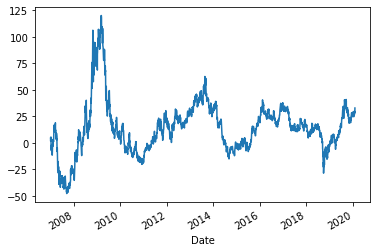

In [61]:
stock_data['yearly_return'].plot()

In [62]:
!sudo mv /content/consultancy/ /content/consultancy_new/ 

In [63]:
!sudo mv /content/consultancy_new/ /content/drive/MyDrive/